In [1]:
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

c:\Users\allan\miniconda3\envs\tf2.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(os.listdir("Saved_models"))

['ModelEpoch10', 'ModelEpoch100', 'ModelEpoch15', 'ModelEpoch20', 'ModelEpoch25', 'ModelEpoch30', 'ModelEpoch35', 'ModelEpoch40', 'ModelEpoch45', 'ModelEpoch5', 'ModelEpoch50', 'ModelEpoch55', 'ModelEpoch60', 'ModelEpoch65', 'ModelEpoch70', 'ModelEpoch75', 'ModelEpoch80', 'ModelEpoch85', 'ModelEpoch90', 'ModelEpoch95']


In [3]:
model_path = os.path.join("Saved_models", "ModelEpoch100")
model = tf.keras.models.load_model(model_path)

In [4]:
generator, discriminator = model.layers
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             6340608   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        3072      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131072    
                                                        

In [5]:
def get_random_image_tensor():
    images_folder_path = "C:\\Users\\allan\\Downloads\\GANFacesDateset"
    random_image_name = random.choice(os.listdir(images_folder_path))
    random_image_path = os.path.join(images_folder_path, random_image_name)
    random_image_file = tf.io.read_file(random_image_path)
    random_image_tensor = tf.image.decode_png(random_image_file, dtype = tf.uint8, channels=3)
    random_image_tensor = tf.image.resize(random_image_tensor, size= (128,128))
    random_image_tensor = tf.cast(random_image_tensor, dtype = tf.float32)
    random_image_tensor = random_image_tensor/255.
    return random_image_tensor

In [6]:
def display_image(image_tensor):
    plt.imshow(image_tensor)
    plt.show()
    pass

def display_saliency_map_with_image(image_tensor, saliency_map, saliency_strength):
    plt.imshow(image_tensor, alpha = (1-saliency_strength))
    plt.imshow(saliency_map, alpha = (saliency_strength))
    plt.show()

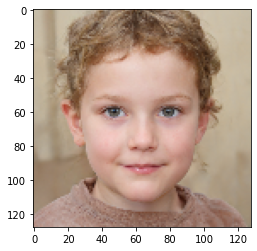

In [7]:
test_image_tensor = get_random_image_tensor()
display_image(test_image_tensor)

In [8]:
test_discriminator_input = tf.expand_dims(test_image_tensor, axis = 0)
prediction = discriminator(test_discriminator_input)

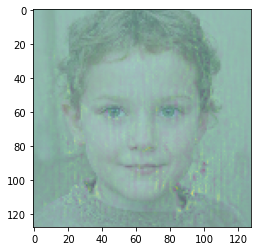

In [11]:
with tf.GradientTape() as tape:
    inputs = test_discriminator_input
    #Will need to differentiate with respect to the inputs later
    tape.watch(inputs)
    #Get actual and expected prdictions to calculate loss later
    actual_prediction = discriminator(inputs)
    expected_prediction = tf.constant(1, shape = (1,1), dtype=tf.float32)
    #Calculate loss
    loss = tf.keras.losses.binary_crossentropy(expected_prediction, actual_prediction)
    #Use loss to calculate gradient
    gradient = tape.gradient(loss, inputs)
    #Normalize the gradient. The values are too low right now
    gradient_range = tf.reduce_max(gradient)-tf.reduce_min(gradient)
    normalized_gradient = (gradient-tf.reduce_min(gradient))/gradient_range

mask = normalized_gradient[0]
mask = tf.reduce_sum(tf.abs(mask), axis = -1)
display_saliency_map_with_image(inputs[0], mask, saliency_strength=0.4)
